# <center> CS559 Homework#3: Decision Tree and Ensemble Methods</center>
## <center> Due: 11/8/2021 Monday at 11:59 PM</center>


In this assignment, you are going to implement four classifiers - **decision tree, random forest, adaboost, and gradient boost**. 
Then check the performance with `sklearn` built-in algorithms.
In this work, splitting into train and test sets is not necessary. 

The provided data has four columns - three features (a, b, and c) and the target (class). Three features are continuous data and the target is a binary, 0 or 1. 

In [1]:
import numpy as np
from random import randrange
from random import seed
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./F21_CS559_HW3_data.csv')

In [3]:
df.replace(1,-1,inplace=True)
df.replace(2,1,inplace=True)

dataset = df.values.tolist()

In [4]:
df.head(5)

,a,b,c,class
0,9.4202,-4.3507,10.3764,-1
1,9.7044,-4.4601,10.6803,-1
2,9.8075,-4.0894,10.6259,-1
3,9.2771,-4.0349,10.1166,-1
4,9.6447,-3.5968,10.2936,-1


### Question 1: Decisition Tree Classifier
- A simple DT implementation (10 pts.)
    - to make the problem simple, implement a decision tree with depth of 3 (the root index is 0).
    - calculate the gini index for each attribute and pick the best attribute for each node.
    - calculate the accuracy using accuracy score. 
- Classification using DecistionTreeClassifier (5 pts)
- Evaluation (5 pts)

In [5]:
# this function returns the node for best split
def best_split(dataset):
    # get all class values
    class_values = list(set(row[-1] for row in dataset))
    # initialize node info
    split_index = 0
    split_value = 0
    split_gini = 1
    split_groups = None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            # create groups for left-side and right-side data in tree
            groups = [[x for x in dataset if x[index]<row[index]],[y for y in dataset if y[index]>=row[index]]]
            # n is total samples for current split
            n = float(sum([len(group) for group in groups])) 
            gini = 0.0
            for group in groups:
                # avoid divide by zero
                if len(group) == 0:
                    continue 
                score = 0.0
                # score the group based on score for each class
                for class_val in class_values:
                    p_val = [x[-1] for x in group].count(class_val) / len(group)
                    score += p_val**2
                # calculate  gini (weighted average impurity)
                gini += (1.0 - score)*(float(len(group)) / n)
            if gini < split_gini:
                split_index, split_value, split_gini, split_groups = index, row[index], gini, groups
    return {'index':split_index, 'value':split_value, 'groups':split_groups}

In [6]:
# Create child splits for a node or make leaf if no splits possible
# split function is called recursively to build a tree from the data
def split(node, current_depth):
    left, right = node['groups']
    del(node['groups'])
    left_class_val,right_class_val = [row[-1] for row in left],[row[-1] for row in right]
    # if no further splits possible create leaf
    if not left or not right:
        classes = [row[-1] for row in (left+right)]
        node['left'] = node['right'] = max(set(left_class_val+right_class_val ), key = (left_class_val+right_class_val).count)
        return
    # if depth 3 is reached create leaf
    if current_depth >= 3:
        node['left'] = max(set(left_class_val),key=left_class_val.count)
        node['right'] = max(set(right_class_val),key=right_class_val.count)
        return
    # create left child
    node['left'] = best_split(left)
    split(node['left'], current_depth+1)
    # create right child
    node['right'] = best_split(right)
    split(node['right'], current_depth+1)

In [7]:
# Make a prediction for each row with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [8]:
def myDecisionTree(X_train,X_test):
    root = best_split(X_train)
    # call split to recursively build a tree from root
    split(root, 1)
    # predict each row from the built tree
    classification = list()
    for row in X_test:
        prediction = predict(root, row)
        classification.append(prediction)
    return(classification)

In [9]:
y_pred_myDT = myDecisionTree(dataset,dataset)
y_test_myDT = [x[-1] for x in dataset]
acc = accuracy_score(y_test_myDT,y_pred_myDT)
print(str(acc*100)+'%')

99.96000000000001%


In [10]:
dtclassifier = DecisionTreeClassifier()
dtclassifier.fit(df.drop(['class'],axis=1),df['class'])
y_pred_DT = dtclassifier.predict(df.drop(['class'],axis=1))
print(str(100*accuracy_score(df['class'],y_pred_DT))+'%')


100.0%


#### DT evaluation

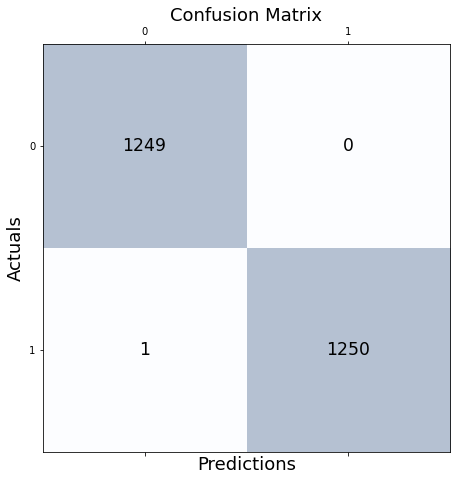

              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00      1249
     class 2       1.00      1.00      1.00      1251

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [11]:
class_names = ['class 1','class 2']

cmat = confusion_matrix(y_test_myDT,y_pred_myDT)
fig,ax = plt.subplots(figsize=(7.5,7.5))
ax.matshow(cmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(x=j,y=i,s=cmat[i,j],va='center',ha='center',size='xx-large')
plt.xlabel('Predictions',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

print(classification_report(y_test_myDT,y_pred_myDT,target_names = class_names))

### Question 2: Random Forest Classifier
- A simle RF implementation (10 pts)
    - make a bootstrap baggin function to make 3 samples.
    - for each sample, run a simple DT from question 1.
    - then average the accuracy. 
- Classification using RandomForestClassifier (5 pts)
- Evaluation (5 pts)

In [12]:
# Random Forest bagging and bootstrap aggregation function
def RF_bagged_sample(dataset, ratio):
    features = list()
    len_features = 2
    # Select random 2 features from dataset, ideally sqrt(total_features) is selected
    # but we only have 3 features so selecting at least 2 makes sense
    while len(features) < len_features:
        index = randrange(len_features)
        if index not in features :
            if index!=3:
                features.append(index)
    features.append(3)

    # Create a subsample from dataset of size dataset * ratio
    sample = list()
    sample_size = round(len(dataset)*ratio)
    while len(sample) < sample_size:
        random_row_idx = randrange(len(dataset))
        random_row = [dataset[random_row_idx][x] for x in features]
        sample.append(random_row)
    
    return sample

In [13]:
def myRandomForest(dataset):
    sub_tree_predictions = list()
    # create 3 samples
    for i in range(3):
        # get bagged samples
        sample = RF_bagged_sample(dataset,0.5)
        # get predictions using mydecisiontree from question 1
        sub_tree_predictions.append(myDecisionTree(sample,dataset))
    # get max prediction for each row from all 3 trees
    pred = [max(sub_tree_predictions[0][x],sub_tree_predictions[1][x],sub_tree_predictions[1][x]) \
        for x in range(len(sub_tree_predictions[0]))]
    return pred

In [14]:
y_pred_myRF = myRandomForest(dataset)
y_test_myRF = [x[-1] for x in dataset]
acc = accuracy_score(y_test_myRF,y_pred_myRF)
print(str(acc*100)+'%')

98.28%


In [15]:
rfclassifier = RandomForestClassifier()
rfclassifier.fit(df.drop(['class'],axis=1),df['class'])
y_pred_RF = rfclassifier.predict(df.drop(['class'],axis=1))
accuracy_score(df['class'],y_pred_RF)

1.0

#### RF evaluation

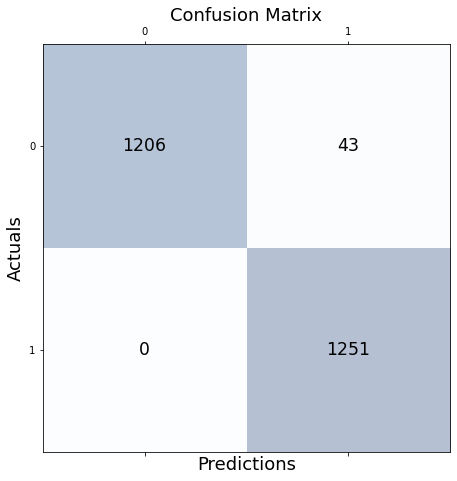

              precision    recall  f1-score   support

     class 1       1.00      0.97      0.98      1249
     class 2       0.97      1.00      0.98      1251

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



In [16]:

class_names = ['class 1','class 2']

cmat = confusion_matrix(y_test_myRF,y_pred_myRF)
fig,ax = plt.subplots(figsize=(7.5,7.5))
ax.matshow(cmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(x=j,y=i,s=cmat[i,j],va='center',ha='center',size='xx-large')
plt.xlabel('Predictions',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

print(classification_report(y_test_myRF,y_pred_myRF,target_names = class_names))

### Question 3: AdaBoost Classifier
- AB implementation (15 pts)
- Classification using AdaBoostClassifier (5 pts)
- Evaluation (5 pts)

In [17]:
def myAdaBoost(dataset):
    X_train = np.array(dataset.iloc[:,:-1])
    X_test = np.array(dataset.iloc[:,:-1])
    y = np.array(dataset.iloc[:,-1:])
    n_classifiers = 5
    X_train = np.float64(X_train)
    N = len(y)
    # initialize weights to 1/n
    w = np.array([1/N for i in range(N)])
    y_pred = 0
    for clf in range(n_classifiers):
        # create prediction function G() using decision stump with initial weight 1/n
        G = DecisionTreeClassifier(max_depth=1).fit(X_train,y,sample_weight=w).predict
        # calculate error by summing misclassified samples from prediction function G()
        err = sum([w[i]*misclassified(y[i]!=G(X_train[i].reshape(1,-1))) for i in range(N)])/sum(w)
        # calculate alpha to update sample weights
        Alpha = np.log((1-err)/err)
        # calculate new weights
        # Misclassified samples get larger weights and correct classifications get smaller weights
        w = [w[i]*np.exp(Alpha*misclassified(y[i]!=G(X_train[i].reshape(1,-1)))) for i in range(N)] 
        # Add predictions weighted by alpha for each clf
        y_pred += Alpha*G(X_test)
    # classify weighted predictions, returns -1 or 1
    f = np.vectorize(classify)
    y_pred = np.where(f(y)==-1,-1,1)
    return y_pred
    
def misclassified(flag):
    return 1 if flag else 0

def classify(x):
    return abs(x)/x if x!=0 else 1       


In [18]:
y_test_myADA = np.array(df.iloc[:,-1:])
y_pred_myADA = myAdaBoost(df)
print(str(accuracy_score(y_test_myADA,y_pred_myADA)*100)+'%')

100.0%


In [19]:

Ada_classifier = AdaBoostClassifier(n_estimators=5,algorithm="SAMME")
Ada_classifier.fit(df.iloc[:,:-1],df.iloc[:,-1:])
y_pred_Ada = Ada_classifier.predict(df.iloc[:,:-1])
print(str(accuracy_score(df.iloc[:,-1:],y_pred_Ada)*100)+'%')


99.72%


#### ADA Evaluation

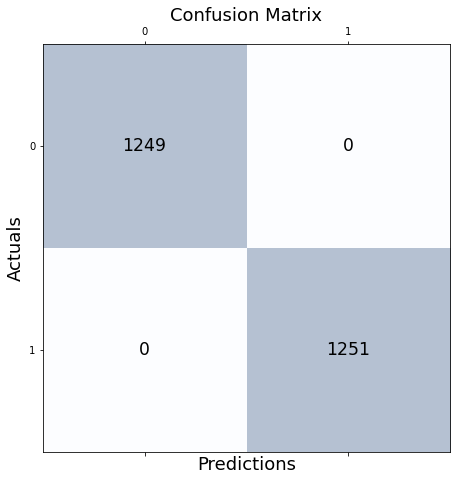

              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00      1249
     class 2       1.00      1.00      1.00      1251

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [20]:
class_names = ['class 1','class 2']

cmat = confusion_matrix(y_test_myADA,y_pred_myADA)
fig,ax = plt.subplots(figsize=(7.5,7.5))
ax.matshow(cmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(x=j,y=i,s=cmat[i,j],va='center',ha='center',size='xx-large')
plt.xlabel('Predictions',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

print(classification_report(y_test_myADA,y_pred_myADA,target_names = class_names))
# likely overfitted due to no train,test split

### Question 4: Gradient Boost Classifier
- GB implementation (15 pts)
- Classification using GradientBoostingClassifier (5 pts)
- Evaluation (5 pts)

In [21]:
from sklearn.tree import DecisionTreeRegressor

def myGradientBoostClassifier(X, y, n_estimators=10):
    # Initialize
    n_samples, n_features = X.shape
    n_estimators = 10
    estimators = []
    F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble
    
    for t in range(n_estimators):
        # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
        residuals = y - F
        # weak learner 1 level decision tree regressor
        h = DecisionTreeRegressor(max_depth=1)
        h.fit(X, residuals)
        # Compute a step length that produces the best improvement in the loss with linesearch
        hreg = h.predict(X)
        loss = lambda a: np.linalg.norm(y - (F + a * hreg))**2
        step = minimize_scalar(loss, method='golden')
        a = step.x
        # Update the ensemble predictions
        F = F + a * hreg
        # Update the ensemble
        estimators.append((a, h))
    
    # prediction
    pred = np.zeros((X.shape[0], ))
    for a,h in estimators:
        pred = pred + a*h.predict(X)    
    y = np.sign(pred)
    y_pred = np.amax(y,axis=1)
    
    return y_pred

In [22]:
X_gb = np.array(df.iloc[:,:-1])
y_gb = np.array(df.iloc[:,-1:])
y_pred_myGB = myGradientBoostClassifier(X_gb,y_gb)
acc = accuracy_score(y_gb,y_pred_myGB)
print(str(acc*100) + '%')

99.28%


In [23]:
clf_gradientboost = GradientBoostingClassifier()
clf_gradientboost.fit(df.iloc[:,:-1],df.iloc[:,-1:])
y_pred_gb = clf_gradientboost.predict(df.iloc[:,:-1])
print(str(accuracy_score(y_gb,y_pred_gb)*100) + '%')

100.0%


#### GB Evaluation

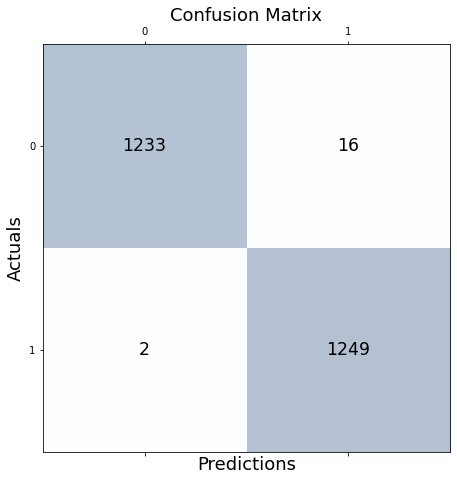

              precision    recall  f1-score   support

     class 1       1.00      0.99      0.99      1249
     class 2       0.99      1.00      0.99      1251

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



In [24]:
class_names = ['class 1','class 2']

cmat = confusion_matrix(y_gb,y_pred_myGB)
fig,ax = plt.subplots(figsize=(7.5,7.5))
ax.matshow(cmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(x=j,y=i,s=cmat[i,j],va='center',ha='center',size='xx-large')
plt.xlabel('Predictions',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

class_names = ['class 1','class 2']
print(classification_report(y_gb,y_pred_myGB,target_names = class_names))

